# Using Real Device

このnotebookは[Qiskit textbook Lab1 Part2](https://qiskit.org/textbook/ch-labs/Lab01_QuantumCircuits.html)の内容です。<br>
量子回路上で実装したANDゲートを量子コンピューターの実機上で実行させてみます。

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np

## デバイスを選択する

ローカル内のcredential情報を使ってアカウントをロード

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

利用可能なproviderを確認することが可能。<br>
全てのproviderはhub/group/projectで特徴づけられていて、オープンユーザーの場合はibm-q/open/mainのみ利用可能。

In [3]:
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

選択したproviderの利用可能なバックエンドを確認

In [4]:
provider = IBMQ.get_provider('ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

`qiskit.tools.jupyter`をインポートすることで選択したバックエンドの情報を閲覧可能

In [5]:
import qiskit.tools.jupyter
backend_ex = provider.get_backend('ibmq_16_melbourne')
backend_ex

<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>

本題に戻って、ANDゲートを実行するためには基本的に3量子ビット以上利用可能なバックエンドを選択することが必要。そこでフィルターをかけて利用可能なバックエンドを探す。

In [7]:
backends = provider.backends(filters = 
    lambda x:x.configuration().n_qubits >= 2 
    and not x.configuration().simulator
    and x.status().operational==True
    )
backends

[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>]

ここからバックエンドを選ぶ際にもっとも待機job数の少ないバックエンドを選ぶのが一つの手法

In [8]:
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters = 
    lambda x:x.configuration().n_qubits >= 2 
    and not x.configuration().simulator
    and x.status().operational==True
    ))
backends

[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [14]:
backend = provider.get_backend('ibmqx2')

## AND演算を量子回路で実現する

In [11]:
qc_and = QuantumCircuit(3)
qc_and.ccx(0,1,2)
qc_and.draw()

q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

In [12]:
qc_and.decompose().draw()

┌───┐      
q_0: ───────────────────■─────────────────────■────■───┤ T ├───■──
                        │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐
q_1: ───────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ TDG ├┤ X ├
     ┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐├───┤└┬───┬┘└───┘
q_2: ┤ H ├┤ X ├┤ TDG ├┤ X ├┤ T ├┤ X ├┤ TDG ├┤ X ├┤ T ├─┤ H ├──────
     └───┘└───┘└─────┘└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘

In [13]:
from qiskit.tools.monitor import job_monitor

In [15]:
def AND(inp1, inp2, backend, layout):
    
    qc = QuantumCircuit(3, 1) 
    qc.reset(range(3))
    
    if inp1=='1':
        qc.x(0)
    if inp2=='1':
        qc.x(1)
        
    qc.barrier()
    qc.ccx(0, 1, 2) 
    qc.barrier()
    qc.measure(2, 0) 
  
    qc_trans = transpile(qc, backend, initial_layout=layout, optimization_level=3)
    job = execute(qc_trans, backend, shots=8192)
    print(job.job_id())
    job_monitor(job)
    
    output = job.result().get_counts()
    
    return qc_trans, output

In [16]:
qc_trans, output = AND('0', '0', backend, [0, 2, 4])

60c88e03c31cf52ffdbd344b
Job Status: job has successfully run


In [17]:
qc_trans

In [18]:
output

{'0': 6906, '1': 1286}

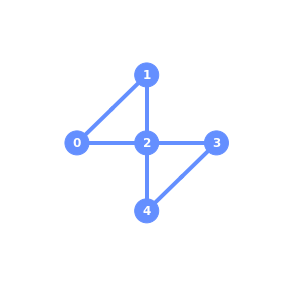

In [19]:
from qiskit.visualization import plot_gate_map, plot_error_map
plot_gate_map(backend)

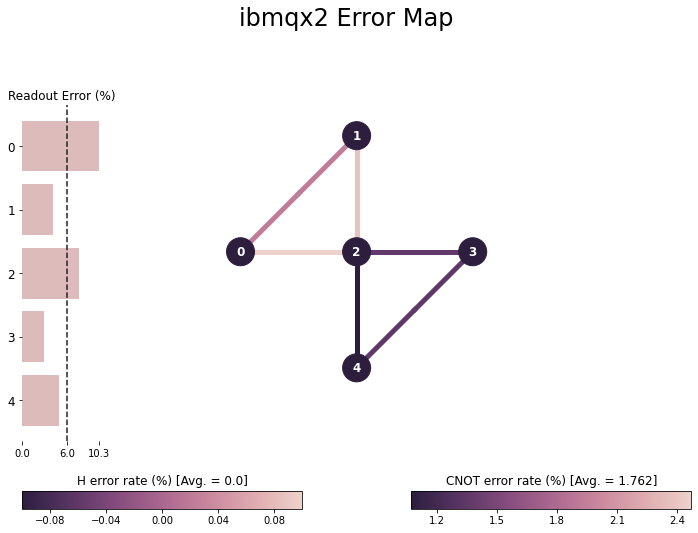

In [20]:
plot_error_map(backend)